## Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

%matplotlib inline

## Read in data

In [2]:
housing = pd.read_csv('data/boston_house_prices.csv')
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## Make a simple prediction using all rows

Our goal here is to see if we can duplicate the results of the Excel workbook in Python. 

### TODO:
- Do a train-test split
- Do cross-validation and regularization
- Estimate parameters using Bootstrapping

In [3]:
features = housing.drop('MEDV', axis=1)
target = housing['MEDV']

In [4]:
simple_regressor = LinearRegression()
simple_regressor.fit(features, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [5]:
predicted = simple_regressor.predict(features)

r2_score(target, predicted)

0.74064266410940938

This compares with Excel's $R^2$ value of 0.740642664! This is good, it means we have a reproducible result.

## Plot of residuals

In Excel, we include a plot of residuals for every feature. We will do the same thing here

In [6]:
# Note this definition of residuals is actually off by a minus sign
# We will correct this in a later commit - this is a deliberate "mistake"
residuals = predicted - target

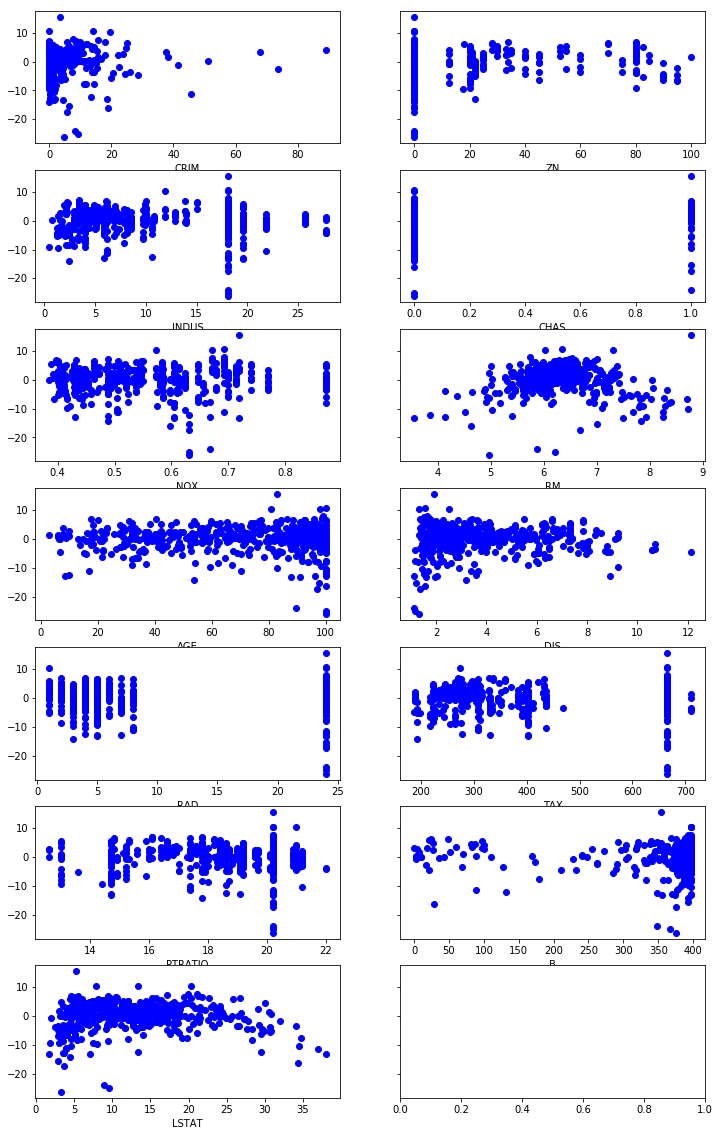

In [7]:
fig, axes = plt.subplots(ncols=2, nrows=len(features.columns)//2 + 1, 
                         sharey=True, squeeze=True, figsize=(12,20))

for index, feature_name in enumerate(features.columns):
    feature_values = features[feature_name]
    col = index % 2
    row = index // 2
    this_plot = axes[row][col]
    this_plot.plot(feature_values, residuals, 'bo')
    this_plot.set_xlabel(feature_name)